https://foss4g.tistory.com/1665

In [1]:
import cv2
import numpy as np
import os
import glob

In [2]:
import matplotlib.pyplot as plt

In [3]:
image_path = './images_480p'

In [4]:
# 체커보드의 차원 정의
# CHECKERBOARD = (6,9) # 체커보드 행과 열당 내부 코너 수
CHECKERBOARD = (6,8) # 체커보드 행과 열당 내부 코너 수
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

In [5]:
# 각 체커보드 이미지에 대한 3D 점 벡터를 저장할 벡터 생성
objpoints = []
# 각 체커보드 이미지에 대한 2D 점 벡터를 저장할 벡터 생성
imgpoints = [] 
# 3D 점의 세계 좌표 정의
objp = np.zeros((1, CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
objp[0,:,:2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)
prev_img_shape = None

In [6]:
images = glob.glob('./ImprovedOcamCalib/FisheyeDataSet/test_images/Fisheye1_*.jpg')

In [7]:
images

['./ImprovedOcamCalib/FisheyeDataSet/test_images/Fisheye1_5.jpg',
 './ImprovedOcamCalib/FisheyeDataSet/test_images/Fisheye1_1.jpg',
 './ImprovedOcamCalib/FisheyeDataSet/test_images/Fisheye1_13.jpg',
 './ImprovedOcamCalib/FisheyeDataSet/test_images/Fisheye1_12.jpg',
 './ImprovedOcamCalib/FisheyeDataSet/test_images/Fisheye1_7.jpg',
 './ImprovedOcamCalib/FisheyeDataSet/test_images/Fisheye1_4.jpg',
 './ImprovedOcamCalib/FisheyeDataSet/test_images/Fisheye1_9.jpg',
 './ImprovedOcamCalib/FisheyeDataSet/test_images/Fisheye1_3.jpg',
 './ImprovedOcamCalib/FisheyeDataSet/test_images/Fisheye1_2.jpg',
 './ImprovedOcamCalib/FisheyeDataSet/test_images/Fisheye1_15.jpg',
 './ImprovedOcamCalib/FisheyeDataSet/test_images/Fisheye1_6.jpg',
 './ImprovedOcamCalib/FisheyeDataSet/test_images/Fisheye1_10.jpg',
 './ImprovedOcamCalib/FisheyeDataSet/test_images/Fisheye1_14.jpg',
 './ImprovedOcamCalib/FisheyeDataSet/test_images/Fisheye1_8.jpg',
 './ImprovedOcamCalib/FisheyeDataSet/test_images/Fisheye1_11.jpg']

In [8]:
# 주어진 디렉터리에 저장된 개별 이미지의 경로 추출
# images = glob.glob(image_path + '/*.jpg')
images = glob.glob('./ImprovedOcamCalib/FisheyeDataSet/test_images/Fisheye1_*.jpg')
for fname in images:
    img = cv2.imread(fname)
    # 그레이 스케일로 변환
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # 체커보드 코너 찾기
    # 이미지에서 원하는 개수의 코너가 발견되면 ret = true
    ret, corners = cv2.findChessboardCorners(gray,
                                             CHECKERBOARD,
                                             cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)
    # 원하는 개수의 코너가 감지되면,
    # 픽셀 좌표 미세조정 -> 체커보드 이미지 표시
    if ret == True:
        objpoints.append(objp)
        # 주어진 2D 점에 대한 픽셀 좌표 미세조정
        corners2 = cv2.cornerSubPix(gray, corners, (11,11),(-1,-1), criteria)
        imgpoints.append(corners2)
        # 코너 그리기 및 표시
        img = cv2.drawChessboardCorners(img, CHECKERBOARD, corners2, ret)
    cv2.imshow('img',img)
    cv2.waitKey(0)
    
cv2.destroyAllWindows()
h,w = img.shape[:2] # 480, 640
# 알려진 3D 점(objpoints) 값과 감지된 코너의 해당 픽셀 좌표(imgpoints) 전달, 카메라 캘리브레이션 수행
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [9]:
mtx, dist

(array([[372.23688083,   0.        , 544.25644455],
        [  0.        , 373.79477539, 371.53921253],
        [  0.        ,   0.        ,   1.        ]]),
 array([[-1.90334853e-01,  2.41855587e-02, -7.24200399e-05,
         -1.33281822e-05, -1.10315146e-03]]))

In [10]:
# calibration_matrix_path = './aruco_marker/calibration_matrix_480p.npy'
# distortion_coefficients_path = './aruco_marker/distortion_coefficients_480p.npy'

calibration_matrix_path = './aruco_marker/calibration_matrix_fisheye.npy'
distortion_coefficients_path = './aruco_marker/distortion_coefficients_fisheye.npy'

In [11]:
def get_calibrated_image(fname, mtx, dist):
    img = cv2.imread(fname)

    h,  w = img.shape[:2]
    ####################################################################3    
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

    # undistort
    dst = cv2.undistort(img, mtx, dist, None, newcameramtx)
     
    # crop the image
    x, y, w, h = roi
    dst = dst[y:y+h, x:x+w]

    return img, dst

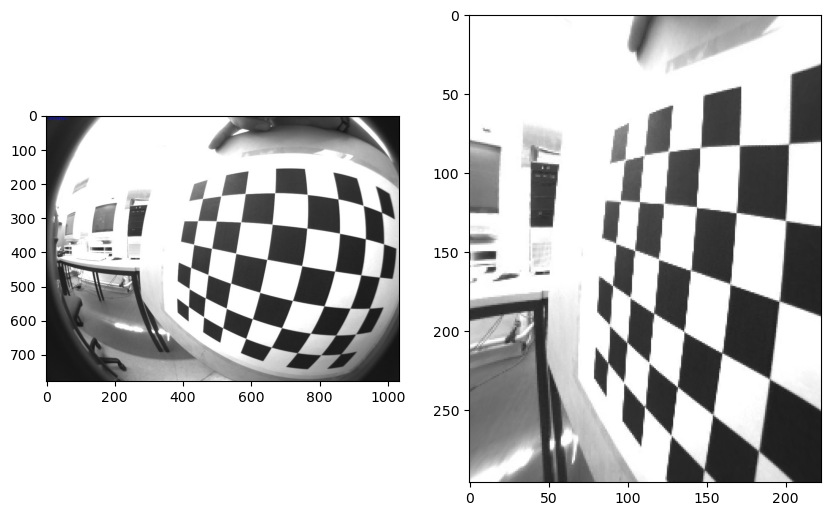

In [21]:
fig = plt.figure(figsize=(10, 10))

for fname in images:
    img, dst = get_calibrated_image(fname, mtx, dist)

    ax1 = plt.subplot(1, 2, 1)
    ax1.imshow(img)
    ax1 = plt.subplot(1, 2, 2)
    ax1.imshow(dst)
    
    break

In [25]:
height, width, _ = img.shape
print(width, height)

1032 778


In [26]:
mtx0 = np.array([[360, 0, width/2], [0, 360, height/2], [0, 0, 1]])
# mtx0 = np.array([[1, 0, 516], [0, 1, 389], [0, 0, 1]])
dist0 = np.array([[0, 0, 0, 0, 0]])

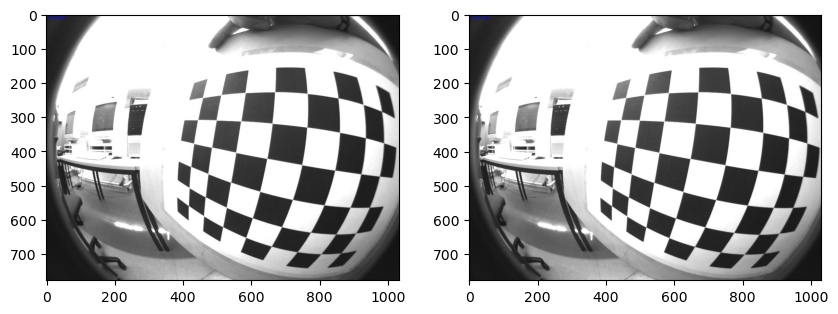

In [27]:
fig = plt.figure(figsize=(10, 10))

for fname in images:
    img, dst = get_calibrated_image(fname, mtx0, dist0)

    ax1 = plt.subplot(1, 2, 1)
    ax1.imshow(img)
    ax1 = plt.subplot(1, 2, 2)
    ax1.imshow(dst)
    
    break

In [12]:
np.save(calibration_matrix_path, mtx)
np.save(distortion_coefficients_path, dist)

In [13]:
!ls ImprovedOcamCalib/FisheyeDataSet/test_images/

checkerboard_sizes.txt	Fisheye1_6.jpg	 Fisheye2_2.jpg  GOPR2.jpg
Fisheye1_10.jpg		Fisheye1_7.jpg	 Fisheye2_3.jpg  GOPR3.jpg
Fisheye1_11.jpg		Fisheye1_8.jpg	 Fisheye2_4.jpg  GOPR4.jpg
Fisheye1_12.jpg		Fisheye1_9.jpg	 Fisheye2_5.jpg  GOPR5.jpg
Fisheye1_13.jpg		Fisheye2_10.jpg  Fisheye2_6.jpg  GOPR6.jpg
Fisheye1_14.jpg		Fisheye2_11.jpg  Fisheye2_7.jpg  GOPR7.jpg
Fisheye1_15.jpg		Fisheye2_12.jpg  Fisheye2_8.jpg  GOPR8.jpg
Fisheye1_1.jpg		Fisheye2_13.jpg  Fisheye2_9.jpg  GOPR9.jpg
Fisheye1_2.jpg		Fisheye2_14.jpg  GOPR001.JPG	 thumbs1.jpg
Fisheye1_3.jpg		Fisheye2_15.jpg  GOPR10.jpg	 thumbs2.jpg
Fisheye1_4.jpg		Fisheye2_16.jpg  GOPR11.jpg	 thumbs3.jpg
Fisheye1_5.jpg		Fisheye2_1.jpg	 GOPR1.jpg
